We ran a Nadaraya-Watson photo-z algorithm from astroML's implementation trained on four photometry bands from DES's science verification data release.  This notebook produces a comparison of the photometric redshift estimates reported by DES (described in Bonnett et al. 2015.), our Nadaraya-Watson redshift estimates based on DES's photometry, and the SDSS confirmed spectroscopic redshifts for all SDSS dr7 and dr12 quasars that were imaged in the DES science verification survey.  We also indicate the object classification that DES applied to all objects to provide an insight into how the methods perform on point sources vs. extended sources in the DES catalog.  

Match summary: <br>
Dr12 quasars matched to DES sva1 gold catalog to obtain DES photometry, then matched to spAll-DR12.fits at https://data.sdss.org/sas/dr12/env/BOSS_SPECTRO_REDUX/ to obtain DCR offsets, then matched to GAIA dr2 to obtain proper motion data.

Dr7 quasars matched to DES sva1 gold catalog to obtain DES photometry, then matched to the DR7 PhotoObj table to obtain DCR offsets, then matched to GAIA dr2 to obtain proper motion data

919 out of 297301 quasars from SDSS DR12 survive the matching process <br>
258 out of 105783 quasars from SDSS DR7 survive the matching process <br>

In [1]:
import numpy as np
from astropy.table import Table
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report
from astroML.linear_model import NadarayaWatson
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import palettable
import richardsplot as rplot
%matplotlib inline

For the following code, the same process is repeated once for each of the four DES photo-z methods. The cells are marked with a comment at the top indicating which method each cell applies to. In general, only the ANNZ method cells are commented and should be used as the primary reference point.

In [2]:
#ANNZ
#read in data tables that contain des data and sdss dr7 and dr12 quasar data
dr7_annz = Table.read('dr7Q+sva1gold+offset+gaia_annz.fits')
dr12_annz = Table.read('dr12Q+sva1gold+spectro+gaia_annz.fits')
dr7_annz = dr7_annz.filled()
dr12_annz = dr12_annz.filled()

In [3]:
#BPZ
dr7_bpz = Table.read('dr7Q+sva1gold+offset+gaia_bpz.fits')
dr12_bpz  = Table.read('dr12Q+sva1gold+spectro+gaia_bpz.fits')
dr7_bpz = dr7_bpz.filled()
dr12_bpz = dr12_bpz.filled()

In [4]:
#SKYNET
dr7_skynet = Table.read('dr7Q+sva1gold+offset+gaia_skynet.fits')
dr12_skynet = Table.read('dr12Q+sva1gold+spectro+gaia_skynet.fits')
dr7_skynet = dr7_skynet.filled()
dr12_skynet = dr12_skynet.filled()

In [5]:
#TPZ
dr7_tpz = Table.read('dr7Q+sva1gold+offset+gaia_tpz.fits')
dr12_tpz = Table.read('dr12Q+sva1gold+spectro+gaia_tpz.fits')
dr7_tpz = dr7_tpz.filled()
dr12_tpz = dr12_tpz.filled()

In [6]:
#ANNZ
#initialize arrays for proper motion and DCR offset
pmra1_annz = dr7_annz['pmra']
pmdec1_annz = dr7_annz['pmdec']
pmra2_annz = dr12_annz['pmra']
pmdec2_annz = dr12_annz['pmdec']
pmabs1_annz = []
pmabs2_annz = []
offsetRa_u1_annz = dr7_annz['offsetRa_u']
offsetRa_g1_annz = dr7_annz['offsetRa_g']
offsetDec_u1_annz = dr7_annz['offsetDec_u']
offsetDec_g1_annz = dr7_annz['offsetDec_g']
offsetRa_u2_annz = dr12_annz['OFFSETRA'].T[0] #OFFSETRA and OFFSETDEC contain offsets in u,g,r,i, and z bands.  
offsetRa_g2_annz = dr12_annz['OFFSETRA'].T[1] #We only want the u and g for now
offsetDec_u2_annz = dr12_annz['OFFSETDEC'].T[0]
offsetDec_g2_annz = dr12_annz['OFFSETDEC'].T[1]
offsetAbs_u1_annz = []
offsetAbs_g1_annz = []
offsetAbs_u2_annz = []
offsetAbs_g2_annz = []
#loop through the proper motions, checking for NaN's and calculating the absolute magnitude of proper motion
for i in range(len(pmra1_annz)):
    if (not np.isnan(pmra1_annz[i])) and (not np.isnan(pmdec1_annz[i])):
        pmabs1_annz = np.append(pmabs1_annz, np.sqrt((pmra1_annz[i]*pmra1_annz[i]) + (pmdec1_annz[i]*pmdec1_annz[i])))
    else:
        pmabs1_annz = np.append(pmabs1_annz, -1000000)
for i in range(len(pmra2_annz)):
    if (not np.isnan(pmra2_annz[i])) and (not np.isnan(pmdec2_annz[i])):
        pmabs2_annz = np.append(pmabs2_annz, np.sqrt((pmra2_annz[i]*pmra2_annz[i]) + (pmdec2_annz[i]*pmdec2_annz[i])))
    else:
        pmabs2_annz = np.append(pmabs2_annz, -1000000)
#loop through offsets and calculate absolute magnitude of DCR offset in u and g bands
for i in range(len(offsetRa_u1_annz)):
    offsetAbs_u1_annz = np.append(offsetAbs_u1_annz, np.sqrt((offsetRa_u1_annz[i]*offsetRa_u1_annz[i]) + (offsetDec_u1_annz[i]*offsetDec_u1_annz[i])))
    offsetAbs_g1_annz = np.append(offsetAbs_g1_annz, np.sqrt((offsetRa_g1_annz[i]*offsetRa_g1_annz[i]) + (offsetDec_g1_annz[i]*offsetDec_g1_annz[i])))
for i in range(len(offsetRa_u2_annz)):
    offsetAbs_u2_annz = np.append(offsetAbs_u2_annz, np.sqrt((offsetRa_u2_annz[i]*offsetRa_u2_annz[i]) + (offsetDec_u2_annz[i]*offsetDec_u2_annz[i])))
    offsetAbs_g2_annz = np.append(offsetAbs_g2_annz, np.sqrt((offsetRa_g2_annz[i]*offsetRa_g2_annz[i]) + (offsetDec_g2_annz[i]*offsetDec_g2_annz[i])))
    
#take the photometry bands, the absolute magnitude of proper motion, the DCR offset in u and g bands, the photometric redshift, and the object classification from DES's data for dr7 quasars
X1_annz = np.vstack([ dr7_annz['MAG_AUTO_G'], dr7_annz['MAG_AUTO_R'], dr7_annz['MAG_AUTO_I'], dr7_annz['MAG_AUTO_Z'], offsetAbs_u1_annz, offsetAbs_g1_annz, pmabs1_annz, dr7_annz['Z_MEAN'], dr7_annz['MODEST_CLASS'] ]).T
#take the sdss dr7 spec-z
y1_annz = np.array(dr7_annz['z_1'])
#repeat the last two lines for dr12 quasars in DES sva1
X2_annz = np.vstack([ dr12_annz['MAG_AUTO_G'], dr12_annz['MAG_AUTO_R'], dr12_annz['MAG_AUTO_I'], dr12_annz['MAG_AUTO_Z'], offsetAbs_u2_annz, offsetAbs_g2_annz, pmabs2_annz, dr12_annz['Z_MEAN'], dr12_annz['MODEST_CLASS'] ]).T
y2_annz = np.array(dr12_annz['Z_PIPE_1']) #this is the dr12 spec-z
#combine our two sets of quasars together
X_annz = np.concatenate((X1_annz, X2_annz))
y_annz = np.concatenate((y1_annz, y2_annz))
#split our quasars into test and training sets, 4/5 and 1/5 respectively
X_train_annz, X_test_annz, y_train_annz, y_test_annz = train_test_split(X_annz, y_annz, test_size=0.2, random_state=84)
#make some empty arrays to separate the photometry bands into
X_traintrue_annz = np.empty((X_train_annz.shape[0], X_train_annz.shape[1]-2), dtype=float) 
X_testtrue_annz = np.empty((X_test_annz.shape[0], X_test_annz.shape[1]-2), dtype=float)
#more empty arrays to hold des photo-z and object class for plotting purposes
DesZs_annz = np.empty((X_test_annz.shape[0], 1), dtype=float) 
ModestClass_annz = np.empty((X_test_annz.shape[0], 1), dtype=int)
#loop over the training set to separate out the photometries
for i in range(len(X_train_annz)):
    X_traintrue_annz[i] = X_train_annz[i][:7] #just the photometry
#loop over each element in the test set to get photometry, des photo-z and des object class
for i in range(len(X_test_annz)):
    X_testtrue_annz[i] = X_test_annz[i][:7] #just the photometry
    DesZs_annz[i] = X_test_annz[i][7] #the DES photo-z
    ModestClass_annz[i] = X_test_annz[i][8] #the DES object classification
#train our model
model_annz = NadarayaWatson('gaussian', 0.05) #gaussian kernel, width of 0.05
#fit the model to our training set, training on 5 DES photometry bands and sdss spec-z
model_annz.fit(X_traintrue_annz, y_train_annz)
#predict a redshift for all quasars in the test set
pred_annz = model_annz.predict(X_testtrue_annz)

In [7]:
#bpz
pmra1_bpz = dr7_bpz['pmra']
pmdec1_bpz = dr7_bpz['pmdec']
pmra2_bpz = dr12_bpz['pmra']
pmdec2_bpz = dr12_bpz['pmdec']
pmabs1_bpz = []
pmabs2_bpz = []
offsetRa_u1_bpz = dr7_bpz['offsetRa_u']
offsetRa_g1_bpz = dr7_bpz['offsetRa_g']
offsetDec_u1_bpz = dr7_bpz['offsetDec_u']
offsetDec_g1_bpz = dr7_bpz['offsetDec_g']
offsetRa_u2_bpz = dr12_bpz['OFFSETRA'].T[0]
offsetRa_g2_bpz = dr12_bpz['OFFSETRA'].T[1]
offsetDec_u2_bpz = dr12_bpz['OFFSETDEC'].T[0]
offsetDec_g2_bpz = dr12_bpz['OFFSETDEC'].T[1]
offsetAbs_u1_bpz = []
offsetAbs_g1_bpz = []
offsetAbs_u2_bpz = []
offsetAbs_g2_bpz = []
for i in range(len(pmra1_bpz)):
    if (not np.isnan(pmra1_bpz[i])) and (not np.isnan(pmdec1_bpz[i])):
        pmabs1_bpz = np.append(pmabs1_bpz, np.sqrt((pmra1_bpz[i]*pmra1_bpz[i]) + (pmdec1_bpz[i]*pmdec1_bpz[i])))
    else:
        pmabs1_bpz = np.append(pmabs1_bpz, -1000000)
for i in range(len(pmra2_bpz)):
    if (not np.isnan(pmra2_bpz[i])) and (not np.isnan(pmdec2_bpz[i])):
        pmabs2_bpz = np.append(pmabs2_bpz, np.sqrt((pmra2_bpz[i]*pmra2_bpz[i]) + (pmdec2_bpz[i]*pmdec2_bpz[i])))
    else:
        pmabs2_bpz = np.append(pmabs2_bpz, -1000000)
for i in range(len(offsetRa_u1_bpz)):
    offsetAbs_u1_bpz = np.append(offsetAbs_u1_bpz, np.sqrt((offsetRa_u1_bpz[i]*offsetRa_u1_bpz[i]) + (offsetDec_u1_bpz[i]*offsetDec_u1_bpz[i])))
    offsetAbs_g1_bpz = np.append(offsetAbs_g1_bpz, np.sqrt((offsetRa_g1_bpz[i]*offsetRa_g1_bpz[i]) + (offsetDec_g1_bpz[i]*offsetDec_g1_bpz[i])))
for i in range(len(offsetRa_u2_bpz)):
    offsetAbs_u2_bpz = np.append(offsetAbs_u2_bpz, np.sqrt((offsetRa_u2_bpz[i]*offsetRa_u2_bpz[i]) + (offsetDec_u2_bpz[i]*offsetDec_u2_bpz[i])))
    offsetAbs_g2_bpz = np.append(offsetAbs_g2_bpz, np.sqrt((offsetRa_g2_bpz[i]*offsetRa_g2_bpz[i]) + (offsetDec_g2_bpz[i]*offsetDec_g2_bpz[i])))
    
#take the photometry bands, the photometric redshift, and the object classification from DES's data for dr7 quasars
X1_bpz = np.vstack([ dr7_bpz['MAG_AUTO_G'], dr7_bpz['MAG_AUTO_R'], dr7_bpz['MAG_AUTO_I'], dr7_bpz['MAG_AUTO_Z'], offsetAbs_u1_bpz, offsetAbs_g1_bpz, pmabs1_bpz, dr7_bpz['Z_MEAN'], dr7_bpz['MODEST_CLASS'] ]).T
#take the sdss dr7 spec-z
y1_bpz = np.array(dr7_bpz['z_1'])
#repeat the last two lines for dr12 quasars in DES sva1
X2_bpz = np.vstack([ dr12_bpz['MAG_AUTO_G'], dr12_bpz['MAG_AUTO_R'], dr12_bpz['MAG_AUTO_I'], dr12_bpz['MAG_AUTO_Z'], offsetAbs_u2_bpz, offsetAbs_g2_bpz, pmabs2_bpz, dr12_bpz['Z_MEAN'], dr12_bpz['MODEST_CLASS'] ]).T
y2_bpz = np.array(dr12_bpz['Z_PIPE_1']) #this is the dr12 spec-z
#combine our two sets of quasars together
X_bpz = np.concatenate((X1_bpz, X2_bpz))
y_bpz = np.concatenate((y1_bpz, y2_bpz))
#split our quasars into test and training sets, 4/5 and 1/5 respectively
X_train_bpz, X_test_bpz, y_train_bpz, y_test_bpz = train_test_split(X_bpz, y_bpz, test_size=0.2, random_state=84)
#make some empty arrays to separate the photometry bands into
X_traintrue_bpz = np.empty((X_train_bpz.shape[0], X_train_bpz.shape[1]-2), dtype=float) 
X_testtrue_bpz = np.empty((X_test_bpz.shape[0], X_test_bpz.shape[1]-2), dtype=float)
#more empty arrays to hold des photo-z and object class for plotting purposes
DesZs_bpz = np.empty((X_test_bpz.shape[0], 1), dtype=float) 
ModestClass_bpz = np.empty((X_test_bpz.shape[0], 1), dtype=int)
#loop over the training set to separate out the photometries
for i in range(len(X_train_bpz)):
    X_traintrue_bpz[i] = X_train_bpz[i][:7] #just the photometry
#loop over each element in the test set to get photometry, des photo-z and des object class
for i in range(len(X_test_bpz)):
    X_testtrue_bpz[i] = X_test_bpz[i][:7] #just the photometry
    DesZs_bpz[i] = X_test_bpz[i][7] #the DES photo-z
    ModestClass_bpz[i] = X_test_bpz[i][8] #the DES object classification
#train our model
model_bpz = NadarayaWatson('gaussian', 0.05) #gaussian kernel, width of 0.05
#fit the model to our training set, training on 5 DES photometry bands and sdss spec-z
model_bpz.fit(X_traintrue_bpz, y_train_bpz)
#predict a redshift for all quasars in the test set
pred_bpz = model_bpz.predict(X_testtrue_bpz)

In [8]:
#skynet
pmra1_skynet = dr7_skynet['pmra']
pmdec1_skynet = dr7_skynet['pmdec']
pmra2_skynet = dr12_skynet['pmra']
pmdec2_skynet = dr12_skynet['pmdec']
pmabs1_skynet = []
pmabs2_skynet = []
offsetRa_u1_skynet = dr7_skynet['offsetRa_u']
offsetRa_g1_skynet = dr7_skynet['offsetRa_g']
offsetDec_u1_skynet = dr7_skynet['offsetDec_u']
offsetDec_g1_skynet = dr7_skynet['offsetDec_g']
offsetRa_u2_skynet = dr12_skynet['OFFSETRA'].T[0]
offsetRa_g2_skynet = dr12_skynet['OFFSETRA'].T[1]
offsetDec_u2_skynet = dr12_skynet['OFFSETDEC'].T[0]
offsetDec_g2_skynet = dr12_skynet['OFFSETDEC'].T[1]
offsetAbs_u1_skynet = []
offsetAbs_g1_skynet = []
offsetAbs_u2_skynet = []
offsetAbs_g2_skynet = []
for i in range(len(pmra1_skynet)):
    if (not np.isnan(pmra1_skynet[i])) and (not np.isnan(pmdec1_skynet[i])):
        pmabs1_skynet = np.append(pmabs1_skynet, np.sqrt((pmra1_skynet[i]*pmra1_skynet[i]) + (pmdec1_skynet[i]*pmdec1_skynet[i])))
    else:
        pmabs1_skynet = np.append(pmabs1_skynet, -1000000)
for i in range(len(pmra2_skynet)):
    if (not np.isnan(pmra2_skynet[i])) and (not np.isnan(pmdec2_skynet[i])):
        pmabs2_skynet = np.append(pmabs2_skynet, np.sqrt((pmra2_skynet[i]*pmra2_skynet[i]) + (pmdec2_skynet[i]*pmdec2_skynet[i])))
    else:
        pmabs2_skynet = np.append(pmabs2_skynet, -1000000)
for i in range(len(offsetRa_u1_skynet)):
    offsetAbs_u1_skynet = np.append(offsetAbs_u1_skynet, np.sqrt((offsetRa_u1_skynet[i]*offsetRa_u1_skynet[i]) + (offsetDec_u1_skynet[i]*offsetDec_u1_skynet[i])))
    offsetAbs_g1_skynet = np.append(offsetAbs_g1_skynet, np.sqrt((offsetRa_g1_skynet[i]*offsetRa_g1_skynet[i]) + (offsetDec_g1_skynet[i]*offsetDec_g1_skynet[i])))
for i in range(len(offsetRa_u2_skynet)):
    offsetAbs_u2_skynet = np.append(offsetAbs_u2_skynet, np.sqrt((offsetRa_u2_skynet[i]*offsetRa_u2_skynet[i]) + (offsetDec_u2_skynet[i]*offsetDec_u2_skynet[i])))
    offsetAbs_g2_skynet = np.append(offsetAbs_g2_skynet, np.sqrt((offsetRa_g2_skynet[i]*offsetRa_g2_skynet[i]) + (offsetDec_g2_skynet[i]*offsetDec_g2_skynet[i])))
    
#take the photometry bands, the photometric redshift, and the object classification from DES's data for dr7 quasars
X1_skynet = np.vstack([ dr7_skynet['MAG_AUTO_G'], dr7_skynet['MAG_AUTO_R'], dr7_skynet['MAG_AUTO_I'], dr7_skynet['MAG_AUTO_Z'], offsetAbs_u1_skynet, offsetAbs_g1_skynet, pmabs1_skynet, dr7_skynet['Z_MEAN'], dr7_skynet['MODEST_CLASS'] ]).T
#take the sdss dr7 spec-z
y1_skynet = np.array(dr7_skynet['z_1'])
#repeat the last two lines for dr12 quasars in DES sva1
X2_skynet = np.vstack([ dr12_skynet['MAG_AUTO_G'], dr12_skynet['MAG_AUTO_R'], dr12_skynet['MAG_AUTO_I'], dr12_skynet['MAG_AUTO_Z'], offsetAbs_u2_skynet, offsetAbs_g2_skynet, pmabs2_skynet, dr12_skynet['Z_MEAN'], dr12_skynet['MODEST_CLASS'] ]).T
y2_skynet = np.array(dr12_skynet['Z_PIPE_1']) #this is the dr12 spec-z
#combine our two sets of quasars together
X_skynet = np.concatenate((X1_skynet, X2_skynet))
y_skynet = np.concatenate((y1_skynet, y2_skynet))
#split our quasars into test and training sets, 4/5 and 1/5 respectively
X_train_skynet, X_test_skynet, y_train_skynet, y_test_skynet = train_test_split(X_skynet, y_skynet, test_size=0.2, random_state=84)
#make some empty arrays to separate the photometry bands into
X_traintrue_skynet = np.empty((X_train_skynet.shape[0], X_train_skynet.shape[1]-2), dtype=float) 
X_testtrue_skynet = np.empty((X_test_skynet.shape[0], X_test_skynet.shape[1]-2), dtype=float)
#more empty arrays to hold des photo-z and object class for plotting purposes
DesZs_skynet = np.empty((X_test_skynet.shape[0], 1), dtype=float) 
ModestClass_skynet = np.empty((X_test_skynet.shape[0], 1), dtype=int)
#loop over the training set to separate out the photometries
for i in range(len(X_train_skynet)):
    X_traintrue_skynet[i] = X_train_skynet[i][:7] #just the photometry
#loop over each element in the test set to get photometry, des photo-z and des object class
for i in range(len(X_test_skynet)):
    X_testtrue_skynet[i] = X_test_skynet[i][:7] #just the photometry
    DesZs_skynet[i] = X_test_skynet[i][7] #the DES photo-z
    ModestClass_skynet[i] = X_test_skynet[i][8] #the DES object classification
#train our model
model_skynet = NadarayaWatson('gaussian', 0.05) #gaussian kernel, width of 0.05
#fit the model to our training set, training on 5 DES photometry bands and sdss spec-z
model_skynet.fit(X_traintrue_skynet, y_train_skynet)
#predict a redshift for all quasars in the test set
pred_skynet = model_skynet.predict(X_testtrue_skynet)

In [9]:
#tpz
pmra1_tpz = dr7_tpz['pmra']
pmdec1_tpz = dr7_tpz['pmdec']
pmra2_tpz = dr12_tpz['pmra']
pmdec2_tpz = dr12_tpz['pmdec']
pmabs1_tpz = []
pmabs2_tpz = []
offsetRa_u1_tpz = dr7_tpz['offsetRa_u']
offsetRa_g1_tpz = dr7_tpz['offsetRa_g']
offsetDec_u1_tpz = dr7_tpz['offsetDec_u']
offsetDec_g1_tpz = dr7_tpz['offsetDec_g']
offsetRa_u2_tpz = dr12_tpz['OFFSETRA'].T[0]
offsetRa_g2_tpz = dr12_tpz['OFFSETRA'].T[1]
offsetDec_u2_tpz = dr12_tpz['OFFSETDEC'].T[0]
offsetDec_g2_tpz = dr12_tpz['OFFSETDEC'].T[1]
offsetAbs_u1_tpz = []
offsetAbs_g1_tpz = []
offsetAbs_u2_tpz = []
offsetAbs_g2_tpz = []
for i in range(len(pmra1_tpz)):
    if (not np.isnan(pmra1_tpz[i])) and (not np.isnan(pmdec1_tpz[i])):
        pmabs1_tpz = np.append(pmabs1_tpz, np.sqrt((pmra1_tpz[i]*pmra1_tpz[i]) + (pmdec1_tpz[i]*pmdec1_tpz[i])))
    else:
        pmabs1_tpz = np.append(pmabs1_tpz, -1000000)
for i in range(len(pmra2_tpz)):
    if (not np.isnan(pmra2_tpz[i])) and (not np.isnan(pmdec2_tpz[i])):
        pmabs2_tpz = np.append(pmabs2_tpz, np.sqrt((pmra2_tpz[i]*pmra2_tpz[i]) + (pmdec2_tpz[i]*pmdec2_tpz[i])))
    else:
        pmabs2_tpz = np.append(pmabs2_tpz, -1000000)
for i in range(len(offsetRa_u1_tpz)):
    offsetAbs_u1_tpz = np.append(offsetAbs_u1_tpz, np.sqrt((offsetRa_u1_tpz[i]*offsetRa_u1_tpz[i]) + (offsetDec_u1_tpz[i]*offsetDec_u1_tpz[i])))
    offsetAbs_g1_tpz = np.append(offsetAbs_g1_tpz, np.sqrt((offsetRa_g1_tpz[i]*offsetRa_g1_tpz[i]) + (offsetDec_g1_tpz[i]*offsetDec_g1_tpz[i])))
for i in range(len(offsetRa_u2_tpz)):
    offsetAbs_u2_tpz = np.append(offsetAbs_u2_tpz, np.sqrt((offsetRa_u2_tpz[i]*offsetRa_u2_tpz[i]) + (offsetDec_u2_tpz[i]*offsetDec_u2_tpz[i])))
    offsetAbs_g2_tpz = np.append(offsetAbs_g2_tpz, np.sqrt((offsetRa_g2_tpz[i]*offsetRa_g2_tpz[i]) + (offsetDec_g2_tpz[i]*offsetDec_g2_tpz[i])))
    
#take the photometry bands, the photometric redshift, and the object classification from DES's data for dr7 quasars
X1_tpz = np.vstack([ dr7_tpz['MAG_AUTO_G'], dr7_tpz['MAG_AUTO_R'], dr7_tpz['MAG_AUTO_I'], dr7_tpz['MAG_AUTO_Z'], offsetAbs_u1_tpz, offsetAbs_g1_tpz, pmabs1_tpz, dr7_tpz['Z_MEAN'], dr7_tpz['MODEST_CLASS'] ]).T
#take the sdss dr7 spec-z
y1_tpz = np.array(dr7_tpz['z_1'])
#repeat the last two lines for dr12 quasars in DES sva1
X2_tpz = np.vstack([ dr12_tpz['MAG_AUTO_G'], dr12_tpz['MAG_AUTO_R'], dr12_tpz['MAG_AUTO_I'], dr12_tpz['MAG_AUTO_Z'], offsetAbs_u2_tpz, offsetAbs_g2_tpz, pmabs2_tpz, dr12_tpz['Z_MEAN'], dr12_tpz['MODEST_CLASS'] ]).T
y2_tpz = np.array(dr12_tpz['Z_PIPE_1']) #this is the dr12 spec-z
#combine our two sets of quasars together
X_tpz = np.concatenate((X1_tpz, X2_tpz))
y_tpz = np.concatenate((y1_tpz, y2_tpz))
#split our quasars into test and training sets, 4/5 and 1/5 respectively
X_train_tpz, X_test_tpz, y_train_tpz, y_test_tpz = train_test_split(X_tpz, y_tpz, test_size=0.2, random_state=84)
#make some empty arrays to separate the photometry bands into
X_traintrue_tpz = np.empty((X_train_tpz.shape[0], X_train_tpz.shape[1]-2), dtype=float) 
X_testtrue_tpz = np.empty((X_test_tpz.shape[0], X_test_tpz.shape[1]-2), dtype=float)
#more empty arrays to hold des photo-z and object class for plotting purposes
DesZs_tpz = np.empty((X_test_tpz.shape[0], 1), dtype=float) 
ModestClass_tpz = np.empty((X_test_tpz.shape[0], 1), dtype=int)
#loop over the training set to separate out the photometries
for i in range(len(X_train_tpz)):
    X_traintrue_tpz[i] = X_train_tpz[i][:7] #just the photometry
#loop over each element in the test set to get photometry, des photo-z and des object class
for i in range(len(X_test_tpz)):
    X_testtrue_tpz[i] = X_test_tpz[i][:7] #just the photometry
    DesZs_tpz[i] = X_test_tpz[i][7] #the DES photo-z
    ModestClass_tpz[i] = X_test_tpz[i][8] #the DES object classification
#train our model
model_tpz = NadarayaWatson('gaussian', 0.05) #gaussian kernel, width of 0.05
#fit the model to our training set, training on 5 DES photometry bands and sdss spec-z
model_tpz.fit(X_traintrue_tpz, y_train_tpz)
#predict a redshift for all quasars in the test set
pred_tpz = model_tpz.predict(X_testtrue_tpz)

In [10]:
#ANNZ
#create some empty arrays to hold objects based on MODEST_CLASS from DES
stars_annz = np.empty(shape=(0,3))
gals_annz = np.empty(shape=(0,3))
uns_annz = np.empty(shape=(0,3))
#Loop through object classifications and sort objects accordingly, grabbing the Nadaraya-Watson prediction, Des's photo-z
#and the sdss spec-z
for i in range(len(ModestClass_annz)):
    if ModestClass_annz[i] == 2:
        stars_annz = np.append(stars_annz, [[pred_annz[i], DesZs_annz[i], y_test_annz[i]]], axis = 0)
    elif ModestClass_annz[i] == 1:
        gals_annz = np.append(gals_annz, [[pred_annz[i], DesZs_annz[i], y_test_annz[i]]], axis = 0)
    else:
        uns_annz = np.append(uns_annz, [[pred_annz[i], DesZs_annz[i], y_test_annz[i]]], axis = 0)

In [11]:
#BPZ
stars_bpz = np.empty(shape=(0,3))
gals_bpz = np.empty(shape=(0,3))
uns_bpz = np.empty(shape=(0,3))

for i in range(len(ModestClass_bpz)):
    if ModestClass_bpz[i] == 2:
        stars_bpz = np.append(stars_bpz, [[pred_bpz[i], DesZs_bpz[i], y_test_bpz[i]]], axis = 0)
    elif ModestClass_bpz[i] == 1:
        gals_bpz = np.append(gals_bpz, [[pred_bpz[i], DesZs_bpz[i], y_test_bpz[i]]], axis = 0)
    else:
        uns_bpz = np.append(uns_bpz, [[pred_bpz[i], DesZs_bpz[i], y_test_bpz[i]]], axis = 0)

In [12]:
#Skynet
stars_skynet = np.empty(shape=(0,3))
gals_skynet = np.empty(shape=(0,3))
uns_skynet = np.empty(shape=(0,3))

for i in range(len(ModestClass_skynet)):
    if ModestClass_skynet[i] == 2:
        stars_skynet = np.append(stars_skynet, [[pred_skynet[i], DesZs_skynet[i], y_test_skynet[i]]], axis = 0)
    elif ModestClass_skynet[i] == 1:
        gals_skynet = np.append(gals_skynet, [[pred_skynet[i], DesZs_skynet[i], y_test_skynet[i]]], axis = 0)
    else:
        uns_skynet = np.append(uns_skynet, [[pred_skynet[i], DesZs_skynet[i], y_test_skynet[i]]], axis = 0)

In [13]:
#TPZ
stars_tpz = np.empty(shape=(0,3))
gals_tpz = np.empty(shape=(0,3))
uns_tpz = np.empty(shape=(0,3))

for i in range(len(ModestClass_tpz)):
    if ModestClass_tpz[i] == 2:
        stars_tpz = np.append(stars_tpz, [[pred_tpz[i], DesZs_tpz[i], y_test_tpz[i]]], axis = 0)
    elif ModestClass_tpz[i] == 1:
        gals_tpz = np.append(gals_tpz, [[pred_tpz[i], DesZs_tpz[i], y_test_tpz[i]]], axis = 0)
    else:
        uns_tpz = np.append(uns_tpz, [[pred_tpz[i], DesZs_tpz[i], y_test_tpz[i]]], axis = 0)

c:\python27\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


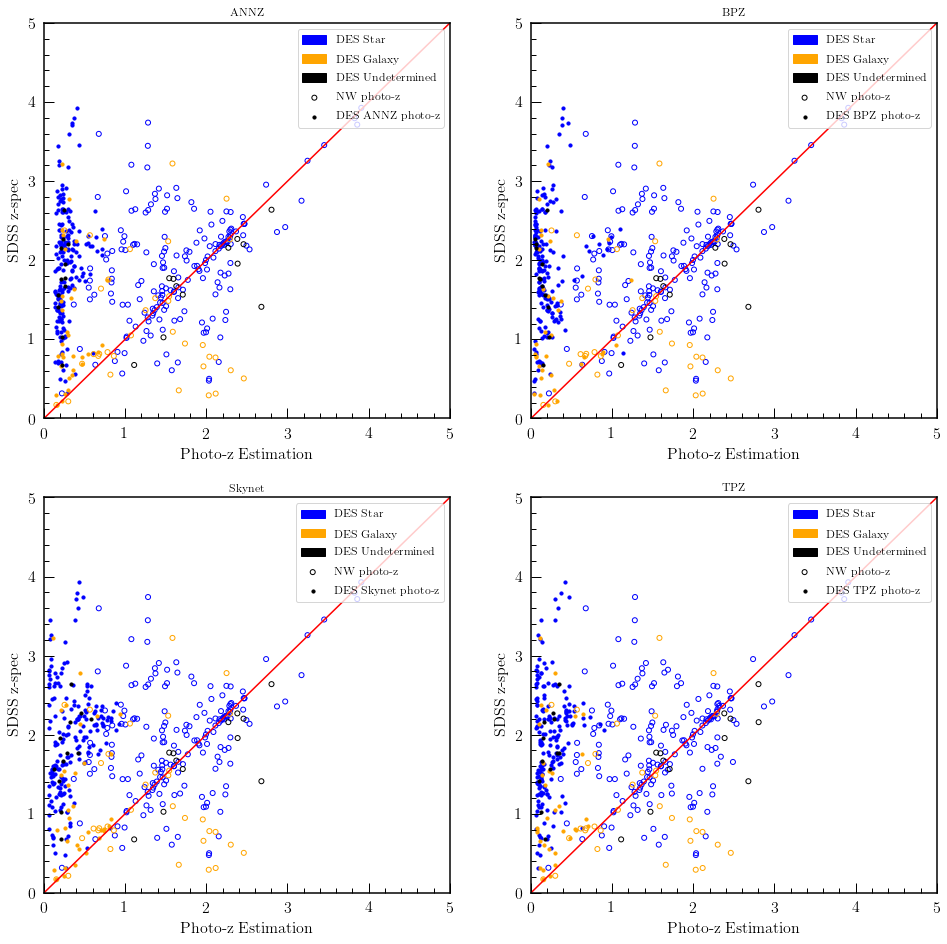

In [14]:
#plotting with MODEST_CLASS
plt.figure(figsize=(16,16))
plt.subplot(221)
#note that stars_annz.T[0] is our photo-z prediction, stars_annz.T[1] is the DES prediction, and stars_annz.T[2] is the zspec
plt.scatter(stars_annz.T[0], stars_annz.T[2], s=25, facecolor='none', edgecolor='blue')
plt.scatter(stars_annz.T[1], stars_annz.T[2], s=10, c='blue')
#same for gals_annz and uns_annz
plt.scatter(gals_annz.T[0], gals_annz.T[2], s=25, facecolor='none', edgecolor='orange')
plt.scatter(gals_annz.T[1], gals_annz.T[2], s=10, c='orange')
#black points (undetermined objects) carry the legend tags for open circles and closed points
legendhelp1_annz = plt.scatter(uns_annz.T[0], uns_annz.T[2], s=25, facecolor='none', edgecolor='k', label = 'NW photo-z')
legendhelp2_annz = plt.scatter(uns_annz.T[1], uns_annz.T[2], s=10, c='k', label = 'DES ANNZ photo-z')
plt.plot([0,1,2,3,4,5], 'r') #plot a one-to-one line for reference
plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel('Photo-z Estimation')
plt.ylabel('SDSS z-spec')
plt.title('ANNZ')
#colored patches for the legend
orange_patch = mpatches.Patch(color='orange', label='DES Galaxy')
blue_patch = mpatches.Patch(color='blue', label='DES Star')
black_patch = mpatches.Patch(color='k', label='DES Undetermined')
plt.legend(handles=[blue_patch, orange_patch, black_patch, legendhelp1_annz, legendhelp2_annz], loc=1)
plt.subplot(222)
plt.scatter(stars_bpz.T[0], stars_bpz.T[2], s=25, facecolor='none', edgecolor='blue')
plt.scatter(stars_bpz.T[1], stars_bpz.T[2], s=10, c='blue')
plt.scatter(gals_bpz.T[0], gals_bpz.T[2], s=25, facecolor='none', edgecolor='orange')
plt.scatter(gals_bpz.T[1], gals_bpz.T[2], s=10, c='orange')
legendhelp1_bpz = plt.scatter(uns_bpz.T[0], uns_bpz.T[2], s=25, facecolor='none', edgecolor='k', label = 'NW photo-z')
legendhelp2_bpz = plt.scatter(uns_bpz.T[1], uns_bpz.T[2], s=10, c='k', label = 'DES BPZ photo-z')
plt.plot([0,1,2,3,4,5], 'r')
plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel('Photo-z Estimation')
plt.ylabel('SDSS z-spec')
plt.title('BPZ')
plt.legend(handles=[blue_patch, orange_patch, black_patch, legendhelp1_bpz, legendhelp2_bpz], loc=1)
plt.subplot(223)
plt.scatter(stars_skynet.T[0], stars_skynet.T[2], s=25, facecolor='none', edgecolor='blue')
plt.scatter(stars_skynet.T[1], stars_skynet.T[2], s=10, c='blue')
plt.scatter(gals_skynet.T[0], gals_skynet.T[2], s=25, facecolor='none', edgecolor='orange')
plt.scatter(gals_skynet.T[1], gals_skynet.T[2], s=10, c='orange')
legendhelp1_skynet = plt.scatter(uns_skynet.T[0], uns_skynet.T[2], s=25, facecolor='none', edgecolor='k', label = 'NW photo-z')
legendhelp2_skynet = plt.scatter(uns_skynet.T[1], uns_skynet.T[2], s=10, c='k', label = 'DES Skynet photo-z')
plt.plot([0,1,2,3,4,5], 'r')
plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel('Photo-z Estimation')
plt.ylabel('SDSS z-spec')
plt.title('Skynet')
plt.legend(handles=[blue_patch, orange_patch, black_patch, legendhelp1_skynet, legendhelp2_skynet], loc=1)
plt.subplot(224)
plt.scatter(stars_tpz.T[0], stars_tpz.T[2], s=25, facecolor='none', edgecolor='blue')
plt.scatter(stars_tpz.T[1], stars_tpz.T[2], s=10, c='blue')
plt.scatter(gals_tpz.T[0], gals_tpz.T[2], s=25, facecolor='none', edgecolor='orange')
plt.scatter(gals_tpz.T[1], gals_tpz.T[2], s=10, c='orange')
legendhelp1_tpz = plt.scatter(uns_tpz.T[0], uns_tpz.T[2], s=25, facecolor='none', edgecolor='k', label = 'NW photo-z')
legendhelp2_tpz = plt.scatter(uns_tpz.T[1], uns_tpz.T[2], s=10, c='k', label = 'DES TPZ photo-z')
plt.plot([0,1,2,3,4,5], 'r')
plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel('Photo-z Estimation')
plt.ylabel('SDSS z-spec')
plt.title('TPZ')
plt.legend(handles=[blue_patch, orange_patch, black_patch, legendhelp1_tpz, legendhelp2_tpz], loc=1)

w.r.t the above plots: Each panel compares one of DES's photo-z methods to astroML's Nadaraya-Watson implementation trained on the 4 DES photometry bands: g, r, i, and z. Open circles are NW photo-z estimations, dots are DES method photo-z estimations. The colors indicate the DES MODEST_CLASS object classification for each object. Blue points were classified as stars, orange points were classified as galaxies, black points were undetermined objects. Red line indicates the one-to-one line along which a given photo-z estimation would be exactly correct.  We find that the DES photo-z methods do poorly for objects that are not dominated by the host galaxy i.e. the quasars that DES classifies as stars.  We also find that the NW photo-z method handles low redshift quasars, but has a large scatter for higher redshift objects while still "correct" on average.  